# Dimsum Calibration

1. Use adaptive binning on STREUSLE validation set with consolidated labels.
2. Use the bin boundaries from the STREUSLE validation set to calibrate dimsum_test.

In [1]:
# Notebook starts in notebooks folder. Change working directory back to streusle-tagger
%cd ../../../

C:\Michael\dev\streusle-tagger


In [2]:
import itertools
import math

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import sklearn.metrics

%matplotlib inline

In [3]:
class Bin:    
    def __init__(self, min_score=None, max_score=None):
        self.scores = []
        self.calibrated_scores = []
        self.labels = []
        self.score_ids = []
        self.min_score = min_score
        self.max_score = max_score
    
    def size(self):
        return len(self.scores);
    
    def average_label(self):
        return np.mean(self.labels)
    
    def average_score(self):
        return np.mean(self.scores)
    
    def weighted_square_error(self):
        square_error = (self.average_score() - self.average_label()) ** 2
        return self.size() * square_error
    
    def add(self, score, label, score_id):
        self.scores.append(score)
        self.labels.append(label)
        self.score_ids.append(score_id)
        return
    
    def set_metadata(self, min_score):
        self.min_score = min_score
        self.max_score = max(self.scores)

In [4]:
def adaptive_binning(confidence_scores, binary_labels, bin_size):
    score_ids = list(range(len(confidence_scores)))
    # Sort by confidence score, but retain an identifier that can be used to reconstruct the original confidence matrix structure
    sorted_data = sorted(zip(confidence_scores, binary_labels, score_ids), key=lambda x: x[0])
    
    bins = []
    i = 0
    
    # Create first bin
    bins.append(Bin(min_score=-1))
    
    # Create more bins as each bin fills up
    for (score, label, score_id) in sorted_data:
        if bins[i].size() < bin_size:
            bins[i].add(score, label, score_id)
        else:
            i += 1
            bins.append(Bin())
            bins[i].add(score, label, score_id)
    
    # Set the metadata values for each bin based on the max value of the previous bin
    bins[0].set_metadata(-1)
    for i, b in enumerate(bins[1:]):
        b.set_metadata(bins[i].max_score)
    
    # Last bin should have a high max score to accomodate rounding errors that may push some confidence scores slightly above 1 (e.g. 1.00004)
    bins[-1].max_score = 999
    return bins

        
def estimate_calibration_error(bins):
    weighted_square_errors = []

    for b in bins:
        weighted_square_errors.append(b.weighted_square_error())
        
    calibration_error = math.sqrt(np.mean(weighted_square_errors))
    return calibration_error


def histogram_binning(confidence_scores, binary_labels, validation_bins):
    score_ids = list(range(len(confidence_scores)))
    sorted_data = sorted(zip(confidence_scores, binary_labels, score_ids), key=lambda x: x[0])
    
    # Create new list of bins for the target dataset, where boundaries are the same as the validation bins
    target_bins = []
    for b in validation_bins:
        target_bins.append(Bin(b.min_score, b.max_score))
    start_bin = 0
    for (score, label, score_id) in sorted_data:
        score_added = False
        for i, b in enumerate(validation_bins[start_bin:]):
            if score >= b.min_score and score < b.max_score:
                target_bins[i + start_bin].add(score, label, score_id)
                score_added = True
                start_bin = start_bin + i
                break
        if score_added == False:
            print(score, validation_bins[start_bin].min_score, validation_bins[start_bin].max_score)
    
    assert len(confidence_scores) == sum([b.size() for b in target_bins])
    return target_bins


def normalize_and_flatten(target_bins):
    all_scores = []
    all_score_ids = []
    
    for b in target_bins:
        all_scores.append(b.calibrated_scores)
        all_score_ids.append(b.score_ids)
        
    flattened_scores = list(itertools.chain(*all_scores))
    flattened_score_ids = list(itertools.chain(*all_score_ids))
    
    # Sort scores by the index we assigned earlier to recover original T x N shape of confidence score matrix, where T is number of tokens and N is the number of labels in the labelset
    # We need this shape in order to normalize by row
    (sorted_scores, sorted_indexes) = [list(_) for _ in zip(*sorted(zip(flattened_scores, flattened_score_ids), key=lambda x: x[1]))]
    scores = np.array(sorted_scores).reshape(-1, len(labelset))
    
    
    denominators = scores.sum(axis=1)
    normalized_rows = []
    for i in range(len(scores)):
        normalized_row = [scores[i][j] / denominators[i] for j in range(len(labelset))]
        normalized_rows.append(normalized_row)
    
    flattened_normalized_scores = list(itertools.chain(*normalized_rows))
    
    return flattened_normalized_scores


def get_accuracy(target_df, calibrated_confidence_scores=None):
    if calibrated_confidence_scores is None:
        predicted_indexes = target_df[target_df["Ground Index"] != -1]["Predicted Index"]
    else:
        reshaped_scores = np.array(calibrated_confidence_scores).reshape(-1, len(labelset))
        predicted_indexes = np.argmax(reshaped_scores, axis=1)
        
    ground_indexes = target_df[target_df["Ground Index"] != -1]["Ground Index"]
    accuracy = sklearn.metrics.accuracy_score(ground_indexes, predicted_indexes)
    return accuracy


def graph(average_scores, average_labels, calibrated_scores, calibrated_labels, title):
    fig, ax = plt.subplots()
    plt.scatter(average_scores, average_labels, c="Blue", alpha=.7)
    plt.scatter(calibrated_scores, calibrated_labels, c="Red", marker="^", alpha=.7)
    line = mlines.Line2D([0, 1], [0, 1], color='#000000', linestyle= "--", alpha=.5)
    transform = ax.transAxes
    ax.set_ylabel('Average Label of Bin')
    ax.set_xlabel('Average Confidence Score of Bin')
    line.set_transform(transform)
    ax.add_line(line)
    plt.savefig(f"calibration/figures/{title}_{labelset_name}.svg", dpi=600)

In [5]:
def calibrate(dataset_name, target_df, bin_size):
    validation_bins = adaptive_binning(validation_confidence_scores, validation_labels, bin_size)
    validation_calibration_error = estimate_calibration_error(validation_bins)
    
    # Temporary fix to accomodate added source column in DiMSUM that's not in STREUSLE
    if dataset_name.startswith("dimsum_test"):
        index_column = 6
        label_start_column = 7
    else:
        index_column = 5
        label_start_column = 6
    
    target_confidence_scores = []
    binary_labels = []
    for i, row in target_df.iterrows():
        label_index = row[index_column]
        if label_index == -1:
            continue
        row_confidence_scores = row[label_start_column:]
        binary_row_labels = np.zeros(len(labelset))
        binary_row_labels[label_index] = 1
        target_confidence_scores.append(list(row_confidence_scores))
        binary_labels.append(list(binary_row_labels))
    
    # These are both lists of lists. Flatten into single list.
    target_confidence_scores = list(itertools.chain(*target_confidence_scores))
    binary_labels = list(itertools.chain(*binary_labels))

    # Use histogram binning to get raw, calibrated confidence scores. Then normalize these scores.
    target_bins = histogram_binning(target_confidence_scores, binary_labels, validation_bins)
    calibrated_confidence_scores = []
    for i, b in enumerate(target_bins):
        b.calibrated_scores = [validation_bins[i].average_label()] * b.size()
    normalized_calibrated_scores = normalize_and_flatten(target_bins)
    
    # Bin the uncalibrated and calibrated scores and get results metrics
    new_target_bins_uncalibrated = adaptive_binning(target_confidence_scores, binary_labels, bin_size)
    new_target_bins_calibrated = adaptive_binning(normalized_calibrated_scores, binary_labels, bin_size)
    pre_tuning_ce = estimate_calibration_error(new_target_bins_uncalibrated)
    post_tuning_ce = estimate_calibration_error(new_target_bins_calibrated)
    pre_tuning_accuracy = get_accuracy(target_df)
    post_tuning_accuracy = get_accuracy(target_df, calibrated_confidence_scores = normalized_calibrated_scores)
    pre_tuning_average_scores = [b.average_score() for b in new_target_bins_uncalibrated]
    pre_tuning_average_labels = [b.average_label() for b in new_target_bins_uncalibrated]
    post_tuning_average_scores = [b.average_score() for b in new_target_bins_calibrated]
    post_tuning_average_labels = [b.average_label() for b in new_target_bins_calibrated]
    
    print(f"STREUSLE validation set calibration error: {validation_calibration_error}")
    print(f"Pre-tuning CE: {pre_tuning_ce:.4}\tPost-tuning CE: {post_tuning_ce:.4}\tPre-tuning Acc: {pre_tuning_accuracy:.4}; \tPost-tuning Acc: {post_tuning_accuracy:.4}")
    print(f"Relative change in calibration error: {((pre_tuning_ce - post_tuning_ce) / pre_tuning_ce):.4}")
    graph(pre_tuning_average_scores, pre_tuning_average_labels, post_tuning_average_scores, post_tuning_average_labels, f"{dataset_name}_bin_size_{bin_size}")

In [6]:
def get_validation_data(validation_df):
    labelset = validation_df.columns[6:]
    label_to_index = dict(zip(labelset, list(range(len(labelset)))))

    validation_confidence_scores = []
    validation_labels = []

    for i, row in validation_df.iterrows():
        confidence_scores = row[6:]
        label = row[4]
        label_index = label_to_index[label]
        binary_labels = np.zeros(len(labelset))
        binary_labels[label_index] = 1
        validation_confidence_scores.append(list(confidence_scores))
        validation_labels.append(list(binary_labels))

    # These are both lists of lists. Flatten into single list.
    validation_confidence_scores = list(itertools.chain(*validation_confidence_scores))
    validation_labels = list(itertools.chain(*validation_labels))
    
    return labelset, validation_confidence_scores, validation_labels

### STREUSLE-test Calibration

In [7]:
# Original labelset
labelset_name = "original"
streusle_validation_df = pd.read_csv("calibration/confidence_scores/validation/all_consolidated.csv")
streusle_test_df = pd.read_csv("calibration/confidence_scores/test/all_consolidated.csv")
labelset, validation_confidence_scores, validation_labels = get_validation_data(streusle_validation_df)

STREUSLE validation set calibration error: 0.06465950742228534
Pre-tuning CE: 0.07226	Post-tuning CE: 0.04179	Pre-tuning Acc: 0.84; 	Post-tuning Acc: 0.8272
Relative change in calibration error: 0.4216


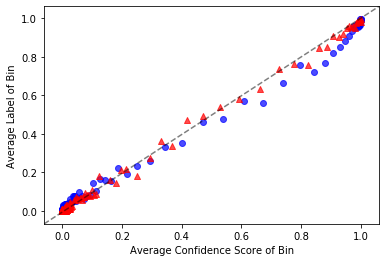

In [8]:
calibrate("streusle_test", streusle_test_df, 200)

### DiMSUM-test Calibration

In [9]:
# Consolidated labelset minus lexcat subtags
labelset_name = "consolidated"
streusle_validation_df = pd.read_csv("calibration/confidence_scores/validation/all_consolidated_no_lexcat.csv")
dimsum_test_df = pd.read_csv("calibration/confidence_scores/dimsum_test/all_consolidated_no_lexcat.csv")
labelset, validation_confidence_scores, validation_labels = get_validation_data(streusle_validation_df)

STREUSLE validation set calibration error: 0.07735339992727545
Pre-tuning CE: 0.1601	Post-tuning CE: 0.09722	Pre-tuning Acc: 0.7542; 	Post-tuning Acc: 0.7467
Relative change in calibration error: 0.3926


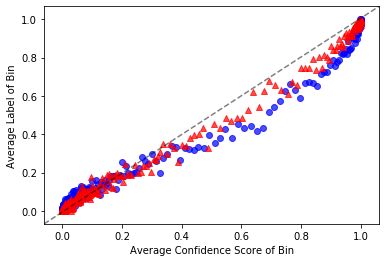

In [10]:
calibrate("dimsum_test", dimsum_test_df, 200)

In [11]:
ted_df = dimsum_test_df[dimsum_test_df["Source"].str.startswith("ted")]
tweets_df = dimsum_test_df[dimsum_test_df["Source"].str.startswith("twee")]
trustpilot_df = dimsum_test_df[dimsum_test_df["Source"].str.startswith("trust")]

Ted
STREUSLE validation set calibration error: 0.07735339992727545
Pre-tuning CE: 0.1078	Post-tuning CE: 0.05836	Pre-tuning Acc: 0.8109; 	Post-tuning Acc: 0.8049
Relative change in calibration error: 0.4586

Tweets
STREUSLE validation set calibration error: 0.07735339992727545
Pre-tuning CE: 0.185	Post-tuning CE: 0.1127	Pre-tuning Acc: 0.6932; 	Post-tuning Acc: 0.6881
Relative change in calibration error: 0.3912

Trustpilot
STREUSLE validation set calibration error: 0.07735339992727545
Pre-tuning CE: 0.1615	Post-tuning CE: 0.1047	Pre-tuning Acc: 0.7865; 	Post-tuning Acc: 0.7756
Relative change in calibration error: 0.3518


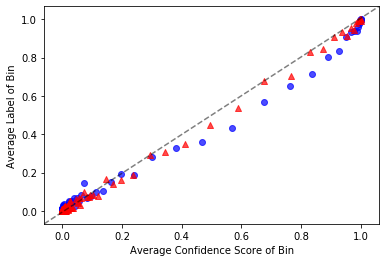

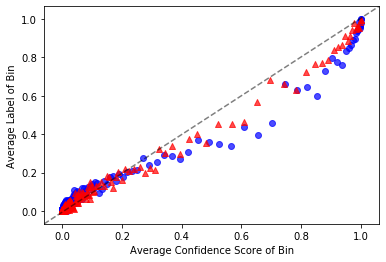

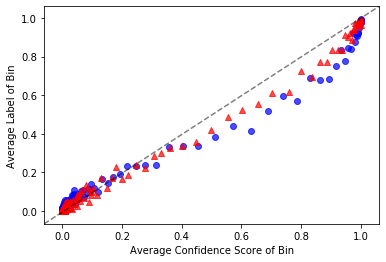

In [12]:
print("Ted")
calibrate("dimsum_test_ted", ted_df, 200)

print("\nTweets")
calibrate("dimsum_test_tweets", tweets_df, 200)

print("\nTrustpilot")
calibrate("dimsum_test_trustpilot", trustpilot_df, 200)